In [2]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
import scipy.io

In [4]:
# Load the .mat file
data = scipy.io.loadmat('/Users/nickgravina/Dropbox/NGravina/RuntSyntetics/data.mat')
TFinput = scipy.io.loadmat('/Users/nickgravina/Dropbox/NGravina/RuntSyntetics/TFinput.mat')

# Access the Rate variables
data = data['data']
construct_index = 4
#data_type = 'Rate_WT_individual'
print(data[0][construct_index]['constructName'][0])

Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1);
Rate_WT_std = np.nanstd(data[0][construct_index]['Rate_WT_individual'], axis=1);
N_WT = data[0][construct_index]['Rate_WT_individual'].shape[1]

Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1);
Rate_null_std = np.nanstd(data[0][construct_index]['Rate_null_individual'], axis=1);
N_null = data[0][construct_index]['Rate_null_individual'].shape[1]

APbins = data[0][construct_index]['APbins']

# Access the Transcription Factor inputs
TFinput = TFinput['TFinput']
Bcd = TFinput[:,0]
Runt = TFinput[:,1]
Runt_Null = TFinput[:,2]

### Remove NaN Data points ###
# Truncate APbins to user-specified range
NoNaN_index_null = ~np.isnan(Rate_null_mean)
NoNaN_index_WT = ~np.isnan(Rate_WT_mean)
NoNaN_index_Bcd = ~np.isnan(Bcd)
NoNaN_index_Runt = ~np.isnan(Runt)
# calculate the AP bins that are not NaNs in both WT and Null datasets
NoNaN_index = NoNaN_index_null * NoNaN_index_WT * NoNaN_index_Bcd * NoNaN_index_Runt

NoNaNindices = np.where(NoNaN_index)[0]

# Truncate the vectors using the range of AP bins
APbins= np.take(APbins, NoNaNindices)
Rate_WT_mean = np.take(Rate_WT_mean, NoNaNindices)
Rate_WT_std = np.take(Rate_WT_std, NoNaNindices)
Rate_WT_err = Rate_WT_std/np.sqrt(N_WT)

Rate_null_mean = np.take(Rate_null_mean, NoNaNindices)
Rate_null_std = np.take(Rate_null_std, NoNaNindices)
Rate_null_err = Rate_WT_std/np.sqrt(N_null)

Bcd = np.take (Bcd, NoNaNindices)
Runt = np.take (Runt, NoNaNindices)
Runt_Null = np.take(Runt_Null, NoNaNindices)

r1-close
6


/var/folders/_r/s5340_w11gldx7_0mf4g4bpw0000gn/T/ipykernel_9411/3248737295.py:11: RuntimeWarning: Mean of empty slice
  Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1);
/var/folders/_r/s5340_w11gldx7_0mf4g4bpw0000gn/T/ipykernel_9411/3248737295.py:16: RuntimeWarning: Mean of empty slice
  Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1);


In [19]:
# Define the model function
def model_1bs(theta, theta_fixed, Bcd, Runt):
    K_r, w_rp = theta
    R, p, K_b, w_bp = theta_fixed
    b = Bcd/K_b
    r = Runt/K_r
    Z = 1 + b**6 + r + r*b**6 + p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp
    return R*((p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp)/Z)

def model_1bs_null(theta, theta_fixed, Bcd, Runt):
    R, p, K_b, w_bp = theta
    b = Bcd/K_b
    Z = 1 + b**6 + p + (b**6)*p*w_bp
    return R*((p + (b**6)*p*w_bp)/Z)


# Define the log-likelihood function
def log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate):
    model_y = model(theta, theta_fixed, Bcd, Runt)
    return -0.5 * np.sum((Rate - model_y)**2)

# Define the log-prior function
def log_prior_1bs_null(theta):
    R, p, K_b, w_bp = theta
    if (50 < R < 400) and (0.0001 < p < 1) and (0.1 < K_b < 100) and (0 < w_bp < 1000):
        return 0.0
    else:
        return -np.inf
def log_prior_1bs(theta):
    K_r, w_rp = theta
    if (0 < K_r < 100) and (0 < w_rp < 1.2):
        return 0.0
    else:
        return -np.inf

# Define the log-posterior function
def log_posterior_1bs_null(theta, model, theta_fixed, Bcd, Runt, Rate):
    lp = log_prior_1bs_null(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate)
def log_posterior_1bs(theta, model, theta_fixed, Bcd, Runt, Rate):
    lp = log_prior_1bs(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate)

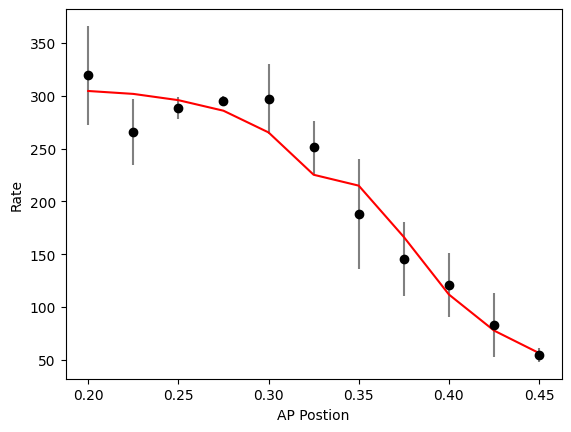

R = 312.888786393011,  p = 0.13700862048823947,  K_b = 91.7810108952854,  w_bp = 423.2419521480201


In [20]:
####  Runt Null Fits ####
# Set up the sampler
ndim = 4
nwalkers = 200
theta0 = [100, 0.1, 10, 50]

# # R, p, K_b, w_bp, K_r, w_rp
# cov = np.diag([1, 0.01, 0.1, 1, 0.1, 0.1])**2  # Covariance matrix
# move = emcee.moves.GaussianMove(cov)

pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1bs_null, 
                                args=(model_1bs_null, [], Bcd, Runt, Rate_null_mean))

# Burn-in phase
pos, _, _ = sampler.run_mcmc(pos, 10000)

# Production phase
for i in range(1):
    sampler.reset()
    sampler.run_mcmc(pos, 20000)

    # Extract the samples
    samples = sampler.get_chain(flat=True)
    
    theta0 = np.median(samples, axis=0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Plot the data and the model
fig, ax = plt.subplots()
ax.errorbar(APbins, Rate_null_mean, yerr=Rate_null_std, fmt='o', color='k', ecolor='gray', capsize=0)
theta_nullParams = np.median(samples, axis=0)
Rate_fit = model_1bs_null(theta_nullParams, [], Bcd, Runt)
ax.plot(APbins, Rate_fit, color='red')
ax.set_xlabel('AP Postion')
ax.set_ylabel('Rate')
plt.show()

print('R = ' + str(theta_nullParams[0]) + ', ', 'p = ' + str(theta_nullParams[1]) + ', ', 'K_b = ' + str(theta_nullParams[2]) + ', ', 
      'w_bp = ' + str(theta_nullParams[3]))

In [21]:
# # Plot the corner plot
# labels = ['R', 'p', 'K_b', 'w_bp', 'K_r', 'w_rp']
# fig = corner.corner(samples, labels=labels)
# plt.show()

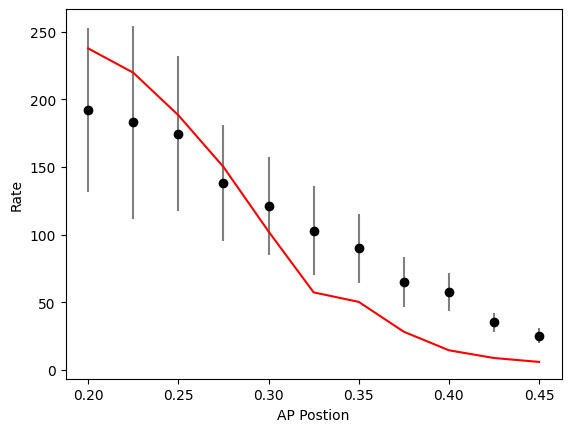

R = 312.888786393011,  p = 0.13700862048823947,  K_b = 91.7810108952854,  w_bp = 423.2419521480201, K_r = 0.0051195227173369984,  w_rp = 0.0873019776103027


In [22]:
#### Runt WT fit using Runt Null parameters ####
# Set up the sampler
ndim = 2
nwalkers = 200
theta0 = [5, 0.5]
theta_fixed = theta_nullParams # Get Runt Null paremeters from previous cell

# # R, p, K_b, w_bp, K_r, w_rp
# cov = np.diag([1, 0.01, 0.1, 1, 0.1, 0.1])**2  # Covariance matrix
# move = emcee.moves.GaussianMove(cov)

pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1bs, 
                                args=(model_1bs, theta_fixed, Bcd, Runt, Rate_WT_mean))

# Burn-in phase
pos, _, _ = sampler.run_mcmc(pos, 10000)

# Production phase
for i in range(1):
    sampler.reset()
    sampler.run_mcmc(pos, 20000)

    # Extract the samples
    samples = sampler.get_chain(flat=True)
    
    theta0 = np.median(samples, axis=0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Plot the data and the model
fig, ax = plt.subplots()
ax.errorbar(APbins, Rate_WT_mean, yerr=Rate_WT_std, fmt='o', color='k', ecolor='gray', capsize=0)
theta_WTParams = np.median(samples, axis=0)
Rate_fit = model_1bs(theta_WTParams, theta_nullParams, Bcd, Runt)
ax.plot(APbins, Rate_fit, color='red')
ax.set_xlabel('AP Postion')
ax.set_ylabel('Rate')
plt.show()

print('R = ' + str(theta_nullParams[0]) + ', ', 'p = ' + str(theta_nullParams[1]) + ', ', 'K_b = ' + str(theta_nullParams[2]) + ', ', 
      'w_bp = ' + str(theta_nullParams[3])+ ',', 'K_r = ' + str(theta_WTParams[0]) + ', ', 'w_rp = ' + str(theta_WTParams[1]))

In [23]:
# # Plot the corner plot
# labels = ['K_r', 'w_rp']
# fig = corner.corner(samples, labels=labels)
# plt.show()